출처: https://www.kaggle.com/code/theoviel/starter-code-eda-and-lgbm-baseline


#패키지 불러오기

In [1]:
%matplotlib inline  

import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
plt.rc('font', family='NanumBarunGothic') 

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

#각 열의 데이터 타입 사전 생성

In [2]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

#데이터 불러오기

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_analysis/reducing-commercial-aviation-fatalities/train.csv',dtype = dtypes)
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_analysis/reducing-commercial-aviation-fatalities/test.csv',dtype = dtypes)

#데이터 정보 확인

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
 #   Column      Dtype   
---  ------      -----   
 0   crew        int8    
 1   experiment  category
 2   time        float32 
 3   seat        int8    
 4   eeg_fp1     float32 
 5   eeg_f7      float32 
 6   eeg_f8      float32 
 7   eeg_t4      float32 
 8   eeg_t6      float32 
 9   eeg_t5      float32 
 10  eeg_t3      float32 
 11  eeg_fp2     float32 
 12  eeg_o1      float32 
 13  eeg_p3      float32 
 14  eeg_pz      float32 
 15  eeg_f3      float32 
 16  eeg_fz      float32 
 17  eeg_f4      float32 
 18  eeg_c4      float32 
 19  eeg_p4      float32 
 20  eeg_poz     float32 
 21  eeg_c3      float32 
 22  eeg_cz      float32 
 23  eeg_o2      float32 
 24  ecg         float32 
 25  r           float32 
 26  gsr         float32 
 27  event       category
dtypes: category(2), float32(24), int8(2)
memory usage: 464.2 MB


#데이터 확인

In [5]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [6]:
test_df.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


#EDA(Exploratory Data Analysis, 탐색적 자료 분석)

Target & Experiment
The pilots experienced distractions intended to induce one of the following three cognitive states:

Channelized Attention (CA) is, roughly speaking, the state of being focused on one task to the exclusion of all others. This is induced in benchmarking by having the subjects play an engaging puzzle-based video game.
Diverted Attention (DA) is the state of having one’s attention diverted by actions or thought processes associated with a decision. This is induced by having the subjects perform a display monitoring task. Periodically, a math problem showed up which had to be solved before returning to the monitoring task.
Startle/Surprise (SS) is induced by having the subjects watch movie clips with jump scares.
Samples are labelled the following way :

A = baseline
B = SS
C = CA
D = DA

##바 차트를 이용해 'event'의 분포값을 확인

Text(0.5, 1.0, '목표값 분포')

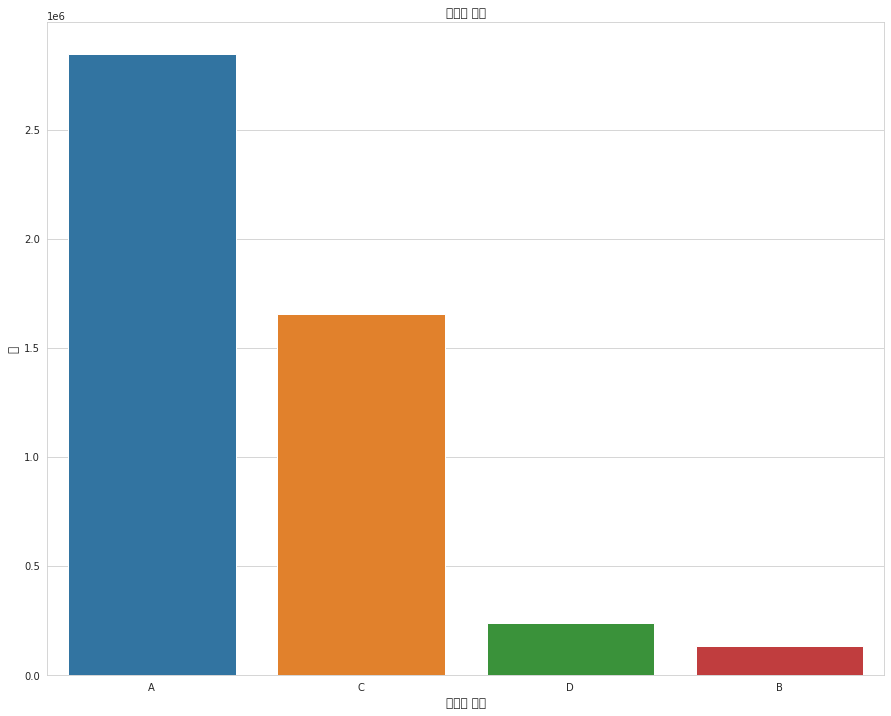

In [7]:
plt.figure(figsize=(15,12))
sns.countplot(train_df['event'])
plt.xlabel("조종사 상태", fontsize= 12 )
plt.ylabel("수", fontsize=12)
plt.title("목표값 분포")

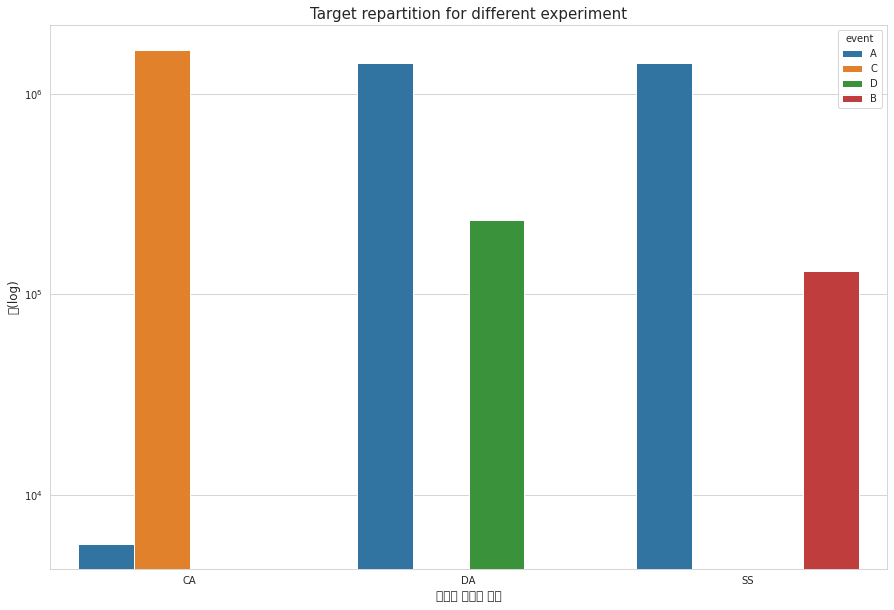

In [8]:
plt.figure(figsize=(15,10))
sns.countplot('experiment', hue='event', data=train_df)
plt.xlabel("조종사 상황과 상태", fontsize = 12)
plt.ylabel('수(log)', fontsize=12)
plt.yscale('log')
plt.title("Target repartition for different experiment", fontsize = 15)
plt.show()

Seat

Which seat the pilot is sitting in.

0 : left seat
1 : right seat

This probably has nothing to do with the outcome of the experiment though.

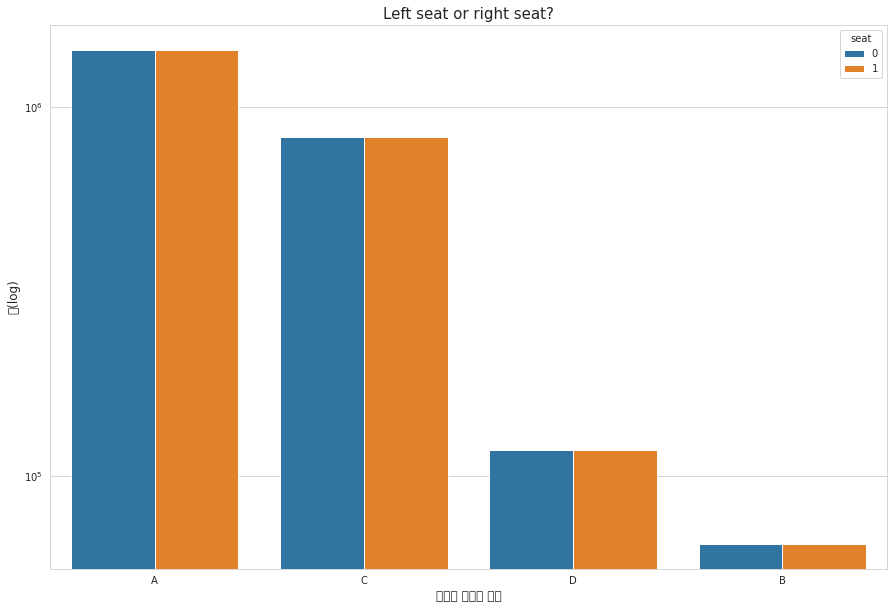

In [9]:
plt.figure(figsize=(15,10))
sns.countplot('event', hue='seat', data=train_df)
plt.xlabel("조종사 자리와 상태", fontsize=12)
plt.ylabel("수(log)", fontsize = 12)
plt.yscale('log')
plt.title("Left seat or right seat?", fontsize = 15)
plt.show()

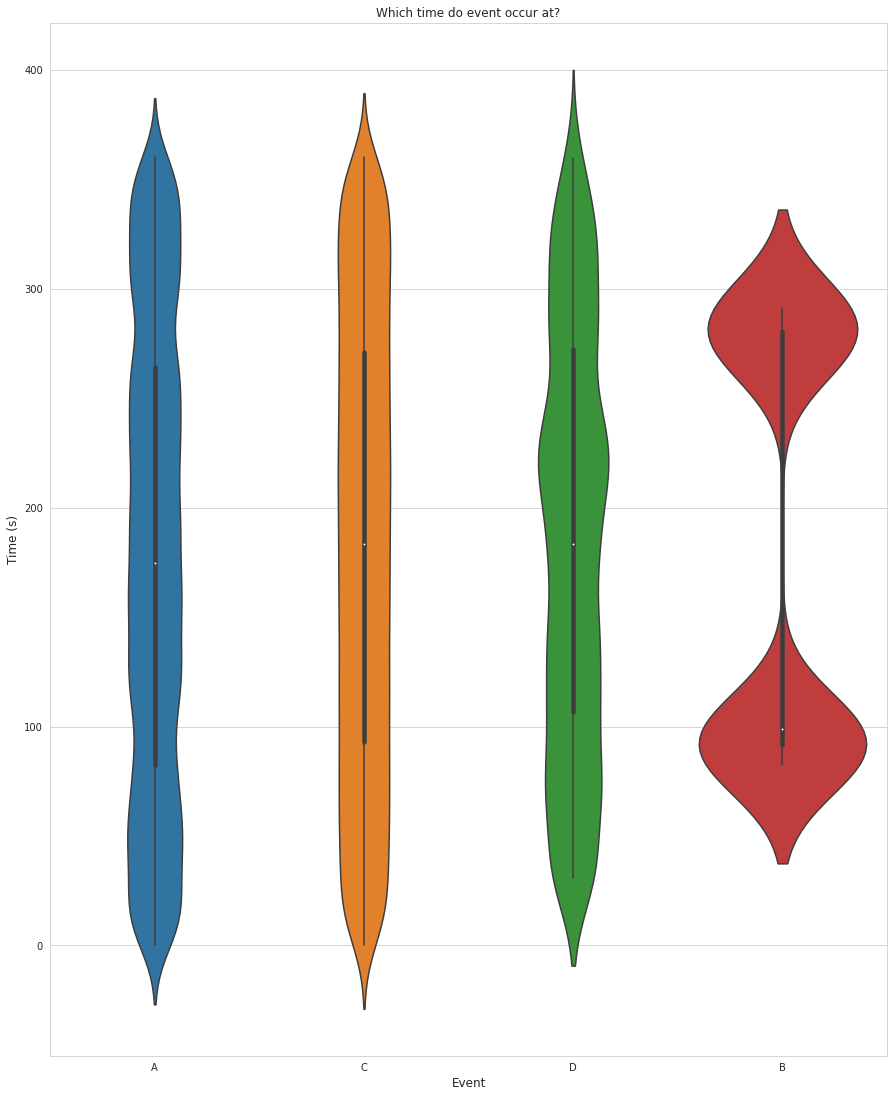

In [10]:
plt.figure(figsize =(15,19))
sns.violinplot(x='event', y='time', data=train_df.sample(50000))
plt.ylabel("Time (s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Which time do event occur at?", fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(test_df['time'],label = 'Test set')
sns.distplot(train_df['time'],label = 'Train set')
plt.legend()
plt.xlabel("Time(s)", fontsize=12)
plt.title("Reparition of the time feature", fontsize=15)